In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')

The equation of motion for a knuckleball has the form: $$C_L(\theta) = a_0 \sin(4\theta - \pi) + a_1 \sum_{i=1}^{n} \Big[\sin(\frac{||\mathbf{s_i}-\mathbf{p}||\pi}{2d} + \pi/2)\cdot \text{sgn}(p^{*}-s_{i}^{*})\Big].$$

Here, $\theta$ is the angle of attack on the ball. The first term accounts for vortex shedding *look up what this is*, and the second accounts for forces produced by the baseball's seams. 

1.0065286881157438

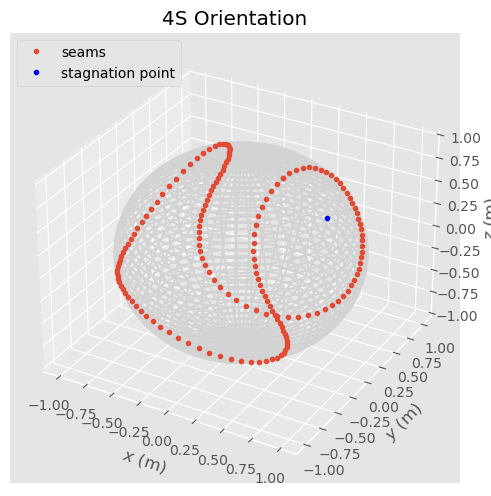

In [61]:
# alpha = np.linspace(1,6,162)
alpha = np.linspace(0,2*np.pi,162)
B = 0.6
F = 1
R = 1
# unnormalized points
xu = np.cos(alpha) - B*np.cos(3*alpha)
yu = np.sin(alpha) + B*np.sin(3*alpha)
zu = F*np.cos(2*alpha)

ru_squared = 1 + B**2 + (F**2-2*B)*(np.cos(2*alpha))**2 + 2*B*(np.sin(2*alpha))**2
ru = np.sqrt(ru_squared)

x = R * xu/ru
y = R * yu/ru
z = R * zu/ru

# draw baseball
u = np.linspace(0, np.pi, 100)
v = np.linspace(0, 2 * np.pi, 100)
x_ball = np.outer(np.sin(u), np.sin(v))
y_ball = np.outer(np.sin(u), np.cos(v))
z_ball = np.outer(np.cos(u), np.ones_like(v))
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_wireframe(x_ball, y_ball, z_ball,color='lightgray')
ax.plot(x, y, z, '.', label='seams')

#plot stagnation point
stag_x = 0.91
stag_y = 0.35
stag_z = 0.25
ax.plot(0.5,0.5,0.25,'.',color='blue',label = 'stagnation point')

ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$y$ (m)")
ax.set_zlabel("$z$ (m)")
ax.legend(loc="upper left", numpoints=1)
ax.figure.tight_layout()
# # fig.savefig("baseball.png")
ax.set_title('4S Orientation')
np.sqrt(stag_x**2+stag_y**2+stag_z**2) #checking that the stagnation point is on the surface of the sphere

In [79]:
#vortex shedding term: 
theta = np.pi/3
t1 = a0*np.sin(4*theta - np.pi)

# seam term
dist_seam = np.zeros(alpha.shape[0])
s_star = np.zeros(alpha.shape[0])
for s_i in range(alpha.shape[0]):
    dist_seam[s_i] = np.sqrt((x[s_i]-stag_x)**2 + (y[s_i]-stag_y)**2 + (z[s_i]-stag_z)**2)
    s_star = z[s_i]
d = 2 * R # ball diameter
a1 = 0.0062

t2 = a1*np.sum(((np.sin((np.linalg.norm(dist_seam)*np.pi / (2*d) + np.pi/2) * np.sign(stag_z - s_star)))))

In [ ]:
C_L = a